# MP6: MoCoGAN

In this MP, you will construct an LSTM layer using PyTorch for use with the system described in Tulyakov, Sergey, et al. ["MoCoGAN: Decomposing motion and content for video generation"](https://arxiv.org/abs/1707.04993) (CVPR 2018). The file you actually need to complete is mp6.py.  The unit tests are provided in run_tests.py and tests/test_visible.py.  All of these are available as part of the code package, [https://courses.engr.illinois.edu/ece417/fa2020/ece417_20fall_mp6.zip](https://courses.engr.illinois.edu/ece417/fa2020/ece417_20fall_mp6.zip).

In [20]:
import numpy as np

import matplotlib.figure
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(417)
np.random.seed(417)

In [21]:
import mp6
import importlib
importlib.reload(mp6)

<module 'mp6' from 'D:\\UIUC Course Material\\ECE 417\\mp\\ece417_20fall_mp6\\mp6.py'>

## How to debug

A number of blocks below have two options: you can either show your own results, or you can show the distributed solutions. In order to decide which one you want to see, you should just comment out one of the lines among some specified pairs.

In [22]:
import json
with open('solutions.json') as f:
    solutions = json.load(f)

## PyTorch basics

For this MP, we will be using the PyTorch machine learning framework in addition to NumPy.

PyTorch has quickly gained widespread use, both in research and in production, for the great depth in its repertoire of functionality and for how much low-level, backend functionality is handled by the library itself compared to what a user of the library needs to implement (including and especially its simple automatic gradient calculation interface).

A number of comparisons to NumPy may hint at the ease with which PyTorch may be used. To start with the basics, just as the primary object of manipulation in NumPy is the N-dimensional array (ndarray), PyTorch's object of choice is the N-dimensional *tensor*. The two behave very similarly, since many methods used in PyTorch are designed with their direct equivalents in NumPy in mind:

In [40]:
print(torch.zeros(5), np.zeros(5))

print(torch.ones(5), np.ones(5))

randa, randb = torch.randn(5), np.random.rand(5)
print(randa, randb)

print(torch.stack([torch.randn(4) for _ in range(3)]),np.stack([np.random.rand(4) for _ in range(3)]))

print(torch.cos(torch.sin(randa)), np.cos(np.sin(randa)))

print(torch.randn(7,5))

tensor([0., 0., 0., 0., 0.]) [0. 0. 0. 0. 0.]
tensor([1., 1., 1., 1., 1.]) [1. 1. 1. 1. 1.]
tensor([-1.3132, -0.5973, -1.3092,  1.4485,  0.9756]) [0.20483592 0.54878112 0.86824018 0.26262122 0.61845413]
tensor([[-0.5157, -0.4333, -0.9255, -0.9348],
        [ 0.1579,  0.2091,  0.9638, -0.2143],
        [ 1.3100,  0.7623,  0.1711, -1.6041]]) [[0.95864834 0.56319795 0.2024566  0.54534184]
 [0.25383653 0.90641528 0.26322816 0.39312142]
 [0.28979289 0.65575112 0.5045464  0.44887392]]
tensor([0.5678, 0.8460, 0.5686, 0.5466, 0.6763]) tensor([0.5678, 0.8460, 0.5686, 0.5466, 0.6763])
tensor([[ 0.3384, -0.7107,  0.9171, -0.3601,  0.7044],
        [ 0.9548,  0.9682,  1.0109, -1.2467,  0.4886],
        [ 0.7153, -1.6595, -1.1049, -1.2983, -0.1454],
        [-0.6800, -2.2051, -0.7017,  0.7189,  0.7940],
        [-1.0841,  0.6139,  0.7188, -0.3209, -1.4922],
        [ 1.7172,  0.4568,  0.8873,  1.1026, -1.5771],
        [-1.0781,  3.5492, -0.3731,  0.6165,  1.3435]])


Of course, as useful as these simple functions may be, they're certainly not the entire story.

A typical PyTorch model consists of, at minimum, a class with two procedures: 1) an initialization method (as with any Python class), in which one assembles a number of layers into a coherent whole, and 2) a ``forward`` method, in which said layers are used in the forward propagation of a number of inputs.

* The first two methods you will be implementing are the initialization and ``forward`` methods of a fully connected layer, ``MyLinear``:

In [30]:
importlib.reload(mp6)
input_dim = solutions["linear_input_size"]
output_dim = solutions["linear_output_size"]
print(input_dim, output_dim)

# Uncomment exactly one of the following lines:
linear_layer = torch.nn.Linear(input_dim,output_dim)
#linear_layer = mp6.MyLinear(input_dim,output_dim)

linear_layer.weight = torch.nn.Parameter(torch.Tensor(solutions["linear_weight"]))
linear_layer.bias = torch.nn.Parameter(torch.Tensor(solutions["linear_bias"]))
input_array = torch.Tensor(solutions["linear_input"])

17 9


The weight and bias of the linear layer, as you saw, could be manipulated to be arbitrary parameters, which we can verify visually:

In [31]:
for parameter_name, parameter_value in linear_layer.named_parameters():
    print(parameter_name,parameter_value)

#for parameter_name, parameter_value in linear_layer1.named_parameters():
    #print(parameter_name,parameter_value)

weight Parameter containing:
tensor([[0.7290, 0.4996, 0.7640, 0.9337, 0.2949, 0.0720, 0.9764, 0.3397, 0.0266,
         0.3905, 0.6720, 0.9313, 0.8576, 0.3298, 0.7498, 0.4529, 0.0965],
        [0.4096, 0.8592, 0.0363, 0.3154, 0.6190, 0.1000, 0.8667, 0.7370, 0.2277,
         0.0459, 0.1082, 0.7327, 0.7475, 0.7376, 0.5509, 0.1384, 0.7359],
        [0.3752, 0.7831, 0.0757, 0.3995, 0.3935, 0.0438, 0.8749, 0.8324, 0.0722,
         0.6362, 0.9524, 0.3266, 0.7590, 0.0098, 0.2488, 0.1925, 0.1815],
        [0.3615, 0.0301, 0.8644, 0.6433, 0.3942, 0.5196, 0.8845, 0.5261, 0.6486,
         0.6415, 0.7552, 0.6456, 0.2910, 0.9155, 0.5477, 0.8185, 0.8215],
        [0.4934, 0.4169, 0.1496, 0.9006, 0.8940, 0.2370, 0.2079, 0.8777, 0.4685,
         0.8738, 0.5724, 0.8766, 0.4736, 0.4901, 0.6226, 0.7466, 0.8769],
        [0.4509, 0.6529, 0.1215, 0.9694, 0.1488, 0.1537, 0.6412, 0.9768, 0.6777,
         0.1403, 0.3170, 0.1620, 0.2776, 0.3291, 0.4282, 0.9461, 0.0852],
        [0.8177, 0.2489, 0.8231, 0.1912, 

This linear layer, by itself, can now be treated as an entire model if we wanted, as you will see below.

To obtain an output from this new model, we can just call the model itself with an input (the arguments after ``self`` in the ``forward`` method):

In [32]:
current_output = linear_layer(torch.Tensor(input_array))
print(current_output)

tensor([5.4148, 5.3680, 5.1604, 5.7956, 5.9180, 4.7404, 5.6566, 6.3425, 4.5361],
       grad_fn=<AddBackward0>)


Now how do we meaningfully train this model? We can use any of the loss functions provided in ``torch.nn``, such as a mean square error loss, to obtain a metric for model performance:

In [33]:
#Uncomment exactly one of the following lines:
#desired_output = torch.randn_like(current_output)
desired_output = torch.Tensor(solutions["linear_output"])

current_loss = torch.nn.MSELoss()(current_output,desired_output)
print(current_loss)

tensor(0., grad_fn=<MseLossBackward>)


To then obtain the gradients of this loss, all we need to do is call the model's ``backward`` method, and then every parameter in our model will have gradients of the error with respect to it defined:

In [34]:
current_loss.backward()

for parameter_name, parameter_value in linear_layer.named_parameters():
    print(parameter_name,parameter_value.grad)

weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])


We can then use an optimizer to adjust those parameters based on the resulting gradients, such as with stochastic gradient descent (with a learning rate `lr` and momentum):

In [35]:
optimizer = torch.optim.SGD(linear_layer.parameters(),lr=0.5,momentum=0.)
optimizer.step()

Now we can print the parameters of our model after this step:

In [36]:
for parameter_name, parameter_value in linear_layer.named_parameters():
    print(parameter_name,parameter_value)

weight Parameter containing:
tensor([[0.7290, 0.4996, 0.7640, 0.9337, 0.2949, 0.0720, 0.9764, 0.3397, 0.0266,
         0.3905, 0.6720, 0.9313, 0.8576, 0.3298, 0.7498, 0.4529, 0.0965],
        [0.4096, 0.8592, 0.0363, 0.3154, 0.6190, 0.1000, 0.8667, 0.7370, 0.2277,
         0.0459, 0.1082, 0.7327, 0.7475, 0.7376, 0.5509, 0.1384, 0.7359],
        [0.3752, 0.7831, 0.0757, 0.3995, 0.3935, 0.0438, 0.8749, 0.8324, 0.0722,
         0.6362, 0.9524, 0.3266, 0.7590, 0.0098, 0.2488, 0.1925, 0.1815],
        [0.3615, 0.0301, 0.8644, 0.6433, 0.3942, 0.5196, 0.8845, 0.5261, 0.6486,
         0.6415, 0.7552, 0.6456, 0.2910, 0.9155, 0.5477, 0.8185, 0.8215],
        [0.4934, 0.4169, 0.1496, 0.9006, 0.8940, 0.2370, 0.2079, 0.8777, 0.4685,
         0.8738, 0.5724, 0.8766, 0.4736, 0.4901, 0.6226, 0.7466, 0.8769],
        [0.4509, 0.6529, 0.1215, 0.9694, 0.1488, 0.1537, 0.6412, 0.9768, 0.6777,
         0.1403, 0.3170, 0.1620, 0.2776, 0.3291, 0.4282, 0.9461, 0.0852],
        [0.8177, 0.2489, 0.8231, 0.1912, 

Notice anything different? Think you *should* have done more to get this change? :-)

* The next two methods you will be implementing are the initialization and ``forward`` methods of a single LSTM cell, ``MyLSTMCell``:

In [37]:
input_dim = solutions["lstmcell_input_size"]
hidden_dim = solutions["lstmcell_hidden_size"]

lstmcell_weight_ih = solutions["lstmcell_weight_ih"]
lstmcell_weight_hh = solutions["lstmcell_weight_hh"]
lstmcell_bias_ih = solutions["lstmcell_bias_ih"]
lstmcell_bias_hh = solutions["lstmcell_bias_hh"]

# Uncomment exactly one of the following lines:
lstmcell_layer = torch.nn.LSTMCell(input_dim, hidden_dim)
# lstmcell_layer = mp6.MyLSTMCell(input_dim, hidden_dim)

lstmcell_layer.weight_ih = torch.nn.Parameter(torch.Tensor(lstmcell_weight_ih))
lstmcell_layer.weight_hh = torch.nn.Parameter(torch.Tensor(lstmcell_weight_hh))
lstmcell_layer.bias_ih = torch.nn.Parameter(torch.Tensor(lstmcell_bias_ih))
lstmcell_layer.bias_hh = torch.nn.Parameter(torch.Tensor(lstmcell_bias_hh))

h_in = torch.Tensor(solutions["lstmcell_h_init"])
c_in = torch.Tensor(solutions["lstmcell_c_init"])
input_array = torch.Tensor(solutions["lstmcell_input"])

In [38]:
lstmcell_layer(input_array, (h_in, c_in))

(tensor([[0.8032, 0.9193, 0.8529, 0.8087, 0.8650, 0.9457, 0.9113, 0.9015, 0.9565,
          0.9572, 0.7985, 0.8595, 0.8611, 0.7883, 0.8062]],
        grad_fn=<MulBackward0>),
 tensor([[1.1083, 1.5898, 1.2672, 1.1263, 1.3172, 1.8059, 1.5412, 1.4850, 1.9103,
          1.9222, 1.0961, 1.2930, 1.2984, 1.0739, 1.1200]],
        grad_fn=<AddBackward0>))

The layers of a neural network are all organized into *modules*, which when combined form a graph of computations (think the graph in lecture 19 slide 5) based on which deeper and deeper gradients can be computed.

If you wish to probe specific layers in your model later, you can of course declare them separately and compose them in your forward layer:

In [37]:
class MyFirstModule(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(MyFirstModule, self).__init__()
        self.linear1 = torch.nn.Linear(input_size,35)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(35,100)
        self.relu6 = torch.nn.ReLU6()
        self.linear3 = torch.nn.Linear(100,output_size)
        self.selu = torch.nn.SELU()
    
    def forward(self, module_input):
        return self.selu(
            self.linear3(
                self.relu6(
                    self.linear2(
                        self.relu(
                            self.linear1(module_input))))))    

If you aren't particularly concerned about probing the layers later, you can compose them on initialization and cut the size of your `forward` method:

In [38]:
class MyFirstModule(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(MyFirstModule, self).__init__()
        self.layers = torch.nn.Sequential([
            torch.nn.Linear(input_size,35),
            torch.nn.ReLU(),
            torch.nn.Linear(35,100),
            torch.nn.ReLU6(),
            torch.nn.Linear(100,output_size),
            torch.nn.SELU()
        ])
    
    def forward(self, module_input):
        return self.layers(module_input)

The remaining four methods you will be implementing pertain to a module, named here simply `LSTM`, which uses both the linear layer and the LSTM cell layer you implemented:

* the initialization method;

* a method which initializes all of the parameters of the model;

* a method which sets an initial hidden state and memory cell; and

* the `forward` method.

Now what might we be using this module for?

In [39]:
input_dim = solutions["lstmcell_input_size"]
hidden_dim = solutions["lstmcell_hidden_size"]
batch_size = solutions["lstm_batch_size"]
forget_bias = solutions["lstm_forget_bias"]
n_frames = solutions["lstm_n_frames"]

lstmcell_weight_ih = torch.Tensor(solutions["lstmcell_weight_ih"])
lstmcell_weight_hh = torch.Tensor(solutions["lstmcell_weight_hh"])
lstmcell_bias_ih = torch.Tensor(solutions["lstmcell_bias_ih"])
lstmcell_bias_hh = torch.Tensor(solutions["lstmcell_bias_hh"])
lstm_linear_weight = torch.Tensor(solutions["lstm_linear_weight"])
lstm_linear_bias = torch.Tensor(solutions["lstm_linear_bias"])
lstm_inputs = torch.Tensor(solutions["lstm_inputs"])
lstm_h = torch.Tensor(solutions["lstm_h"])
lstm_c = torch.Tensor(solutions["lstm_c"])

lstmlayer = mp6.LSTM(input_dim, hidden_dim)
lstmlayer.lstm.weight_ih = torch.nn.Parameter(lstmcell_weight_ih)
lstmlayer.lstm.bias_ih = torch.nn.Parameter(lstmcell_bias_ih)
lstmlayer.lstm.weight_hh = torch.nn.Parameter(lstmcell_weight_hh)
lstmlayer.lstm.bias_hh = torch.nn.Parameter(lstmcell_bias_hh)
lstmlayer.linear.weight = torch.nn.Parameter(lstm_linear_weight)
lstmlayer.linear.bias = torch.nn.Parameter(lstm_linear_bias)
lstmlayer.h = torch.autograd.Variable(torch.Tensor(lstm_h))
lstmlayer.c = torch.autograd.Variable(torch.Tensor(lstm_c))

# Uncomment exactly one of the following lines:
# lstm_output = lstmlayer(lstm_inputs, n_frames)
lstm_output == torch.Tensor(solutions["lstm_output"])

NotImplementedError: You need to write this part!

## What are GANs?

You have seen in lecture a discussion of Deep Voxel Flow, which has been used to bilinearly interpolate between two images in time using a procedure quite similar to barycentric coordinates. For this MP, however, we will be generating (hallucinating?) video frames from scratch using a simple GAN.

The typical GAN consists of a *generator* of data, this ultimately being a transformation of some vector in what can be considered a *latent space* of possible candidate data, and a *discriminator* which attempts to discern real data from some dataset from that produced by the generator. For images and other high-dimensional data, the discriminator models are usually implemented as convolutional neural networks (remember lectures 9 and 10?), while the generator models are conversely implemented as *de*convolutional neural networks (that is, the reverse process).

The networks are called *adversarial* because these two models are trained in an alternating fashion over some period, with the generator producing better quality images (as an "attempt" to "fool" the discriminator) and the discriminator getting better at classifying real images from fake (as an "attempt" to "not be fooled" by the generator).

(A more detailed discussion of GANs in general is to come in Thursday's lecture; stay tuned!)

## MoCoGAN

In MoCoGAN, there are in fact two discriminators; one which discriminates between real and fake videos $D_V$ and another which discriminates between real and fake images (that is, the frames of those videos) $D_I$. Since the generator $G_I$ used in MoCoGAN only produces frames—which are later concatenated into videos—any improvements in the generator in this regard must come from whatever produces the input to the generator which corresponds to the animation in the output, such as the LSTM (the unlabeled pink element in the diagram).

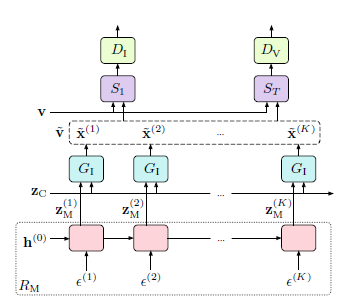

The input to the generator in this case consists of a vector $\{\mathbf{z}_M\}_{i=1}^{K}$, from what is considered the *mo*tion latent subspace of the overall latent space of candidate videos, and a similar vector $\mathbf{z}_C$ from a similar *co*ntent latent subspace, which is kept constant. The former of these is generated by feeding an input, such as random noise, to an LSTM and propagating it over a number of timesteps.

The developers of MoCoGAN demonstrated the effectiveness of this GAN with, among other datasets as a basis, a collection of videos of tai chi (some sample frames from the resulting generator are shown below). The specific implementation of this GAN that you are provided has been trained on the classification database from ["Actions as Space-Time Shapes"](http://www.wisdom.weizmann.ac.il/%7Evision/SpaceTimeActions.html) (ICCV 2005, PAMI 2007) and outputs 96x96 videos roughly 2-4 seconds long. (If they were any larger, though not necessarily if they were any longer, you might run into problems running this if you lack a GPU.)

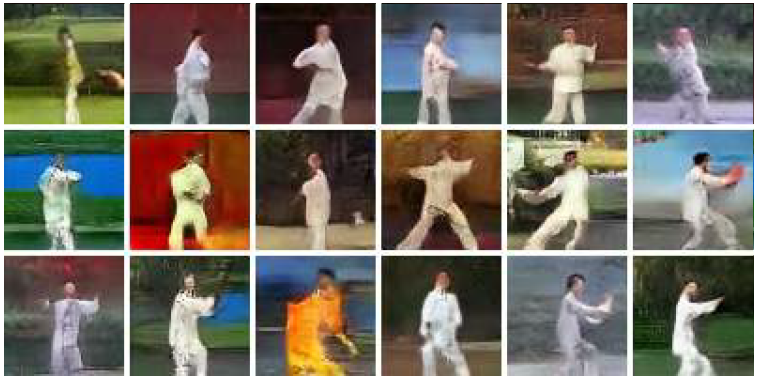

To see what videos you are able to generate, try running `mp6.py` directly once you've implemented all of the functions noted earlier in this notebook.

## Caveats for this MP

The three layers you will be implementing here, as mentioned above, are a linear layer, a single LSTM cell, and an LSTM layer using both of these. The interfaces of the first two of these are meant to resemble those of the ``Linear`` and ``LSTMCell`` modules in ``torch.nn``, to help you if you wish to probe more deeply how your implementation compares with that of PyTorch. Do note the following, however:

* You are not allowed to use any modules listed under "Linear Layers" or "Recurrent Layers" in [the list of modules in torch.nn](https://pytorch.org/docs/stable/nn.html) within your implementation of this MP, although you are welcome to peruse their documentation and source code as provided there. The use of modules from those two sublists will be checked manually and you will lose points if their use is discovered.
* You are encouraged, rather than wholesale importing ``torch``, ``torch.nn``, or ``torch.nn.functional`` directly, to instead import specific functions or modules as you find necessary (that is, use ``from torch import sort`` or ``from torch.nn.functional import hardtanh``). For your convenience, the suite of functions and modules that were used in the reference implementation of this MP are provided as a list of imports at the top of ``mp6.py``.

## Extra Credit: Gated Recurrent Units

The recurrent layer you will be implementing for this MP is a long short-term memory, with four sets of trainable parameters and equally complex computations in which they are used. Very frequently, however, one encounters platforms that, while recurrent, do not use LSTMs, but instead use something very much related: gated recurrent units (GRUs).

The GRU was introduced in Kyunghyun Cho et al. ["Learning Phrase Representations using RNN Encoder–Decoderfor Statistical Machine Translation"](https://arxiv.org/abs/1406.1078) as a unit "motivated by the LSTM unit but [...] much simpler to compute and implement". It omits the output gate of the LSTM and adjusts the remaining gates so that the hidden state at time $t$ is an affine combination of the state at time $t-1$ (scaled by an *update* gate—like the LSTM's forget gate) and a new state (scaled by a *reset* gate—think the LSTM's memory cell but with an input scaled by the input gate). Although theoretically the GRU is somewhat limited in terms of its processing of much longer sequences when compared to the LSTM, it has been shown to rival the LSTM (and in some cases outperform it) in many of the same experiments, with a noticeable reduction in training time and complexity.

* The original MoCoGAN implementation actually used a GRU layer to generate the motion portion of the generator's input, rather than an LSTM. As an extra credit exercise, you can reimplement this MP to use a GRU cell internally, rather than an LSTM cell. (Get in touch with either the professor or myself to obtain a pretrained GRU model for assessment, or the corresponding generator code if you wish to retrain this GAN yourself.) A successful implementation will receive 10% extra credit. How does the quality of the generated videos compare to the use of the LSTM on the same dataset?